In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns


In [2]:
from molten.data_drift.kdq_tree import KdqTree

In [3]:
# Drift 1: change the mean & var of line item B in 2009, means will revert for 2010 on
# Drift 2: change the variance of line item c and d in 2012 by replacing some with the mean
# keep same mean as other years, revert by 2013
# Drift 3: change the correlation of line item e and f in 2015 (go from correlation of 0 to correlation of 0.5)
# Drift 4: change mean and var of H and persist it from 2018 on
# Drift 5: change mean and var just for a year of J in 2021

#assuming test -> reference upon drift, accurate detection would be roughly:
drift_rough = pd.DataFrame({'tax_yr':[2009, 2010, 2012, 2013, 2015, 2016, 2018, 2021]})
drift_rough['drift_true'] = 'drift'

In [4]:
df_orig = pd.read_csv(os.path.join("src", "molten", "tools", "artifacts", "fake_wls_eligibility_FINAL.csv"),
                index_col = 'tin')

In [5]:
df = pd.concat([df_orig, pd.get_dummies(df_orig.fil_stat, prefix='fil_stat')], axis=1)

In [6]:
df.drop(columns=['fil_stat'], inplace=True)

In [7]:
np.random.seed(123)
status = pd.DataFrame(columns=['tax_yr', 
                                'kld_crit', 
                                'kld_curr',
                                'drift'])
det = KdqTree(stream=False)
for group, subdf in df.groupby('tax_yr'):
    det.update(subdf.drop(columns=['tax_yr']).values)
    #calculate this "by hand" since it doesn't have an attrib
    kld_curr = det._kdqtree.kl_distance(tree_id1="build", tree_id2="test") if det.samples_since_reset > 1 else None
    status = status.append(pd.Series({'tax_yr':group, 
                                        'kld_crit':det._critical_dist, 
                                        'kld_curr':kld_curr,
                                        'drift':det.drift_state}), ignore_index=True)
    if det.drift_state is not None:
        #update the reference window if drift is detected
        det.update(subdf.drop(columns=['tax_yr']).values)


In [9]:
status.merge(drift_rough, how='left', on='tax_yr')

,tax_yr,kld_crit,kld_curr,drift,drift_true
0,2007.0,0.005868,NaN,NaN,NaN
1,2008.0,0.005868,0.004507,NaN,NaN
2,2009.0,0.005868,4.361967,drift,drift
3,2010.0,0.004055,3.294759,drift,drift
4,2011.0,0.006169,0.003604,NaN,NaN
5,2012.0,0.006169,0.037700,drift,drift
6,2013.0,0.002702,0.031556,drift,drift
7,2014.0,0.003802,0.002060,NaN,NaN
8,2015.0,0.003802,0.007339,drift,drift
9,2016.0,0.003103,0.005399,drift,drift


In [10]:
status['threshold_dist'] =  status.kld_curr - status.kld_crit

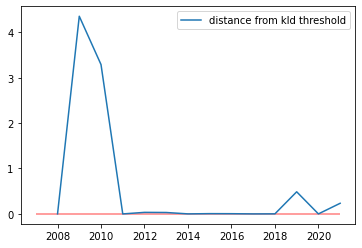

In [13]:
# plt.plot(status.tax_yr, status.kld_crit, label='kld threshold')
# plt.plot(status.tax_yr, status.kld_curr, label='kld')
plt.plot(status.tax_yr, status.threshold_dist, label='distance from kld threshold')
# plt.ylim((-.05, .05))
plt.hlines(xmin=status.tax_yr.min(), xmax=status.tax_yr.max(), y=0, alpha=.5, color='red')
plt.legend()
